<a href="https://colab.research.google.com/github/jacobjuneau6/imaghe_recog/blob/main/oxford_iiit_pet_dataset_classification_with_fastai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to the dataset
The Oxford-IIIT Pet Dataset is a 37 category pet dataset with roughly 200 images for each class created by the Visual Geometry Group at Oxford. The images have a large variations in scale, pose and lighting. All images have an associated ground truth annotation of breed, head ROI, and pixel level trimap segmentation. Here we will use the fastai library to train a model for multi-class classification of cat and dog breeds. Future kernels will look at bounding-box detection and image segmentation with the fastai library.

This kernel was inspired by [lesson 1](https://github.com/fastai/course-v3/blob/master/nbs/dl1/lesson1-pets.ipynb) of the [2019 version of fast.ai Part 1](https://course.fast.ai)

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Let's import all the necessary libraries. This is very easy with fastai, as the computer vision functionality is part of the `fastai.vision` module:

In [2]:
from fastai.vision import *

# Looking at the data

In [3]:
import os
cwd = os.getcwd()
print(cwd)
path_img = Path('../input/images/images')

/content


NameError: ignored

In [ ]:
fnames = get_image_files(path_img)
fnames[:5]

[PosixPath('../input/images/images/american_pit_bull_terrier_16.jpg'),
 PosixPath('../input/images/images/leonberger_200.jpg'),
 PosixPath('../input/images/images/english_cocker_spaniel_35.jpg'),
 PosixPath('../input/images/images/Siamese_67.jpg'),
 PosixPath('../input/images/images/boxer_77.jpg')]

We will use a regex expression to extract the labels of the images and load into the `ImageDataBunch` class, which is the class for inputting image data into the neural network for the fastai library.

In [ ]:
np.random.seed(2) #random seed for reproducibility
pat = r'/([^/]+)_\d+.jpg$' #regex expression

In [ ]:
sz = 128
bs = 64

In [ ]:
data = ImageDataBunch.from_name_re('.', fnames, pat, ds_tfms=get_transforms(), size=sz, bs=bs
                                  ).normalize(imagenet_stats)

Note that we will resize the images to `sz=128` and load our data into the neural network with a batch size of `bs=64`. We use default transformations for image augmentation to improve training and generalization.

Let's look at some sample data:

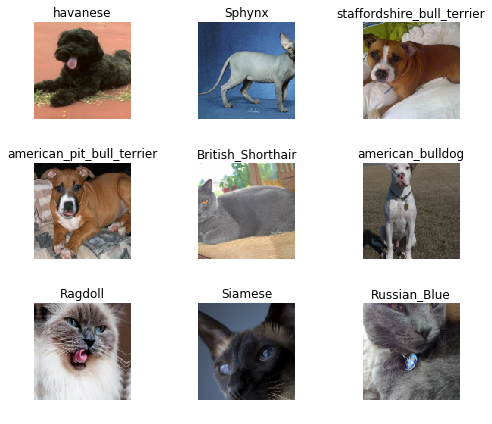

In [ ]:
data.show_batch(rows=3, figsize=(7,6))

In [ ]:
print(data.classes)
len(data.classes),data.c

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


(37, 37)

We have 37 classes as we expected.

# Training: Resnet50

We will now start training a new model. We will take a convolutional neural network architecture (ResNet50) pretrained on the [ImageNet](http://www.image-net.org/) dataset, an add a new layer to output the predictions for our given dataset. We will then train this last layer. The idea behind this is that the ResNet50 trained on the ImageNet dataset already has learnt to identify important features and does not need to be retrained from scratch. So we only train the last layer for our particular task.

In [ ]:
from fastai.metrics import accuracy
learn = create_cnn(data, models.resnet50, metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth


ConnectionError: HTTPSConnectionPool(host='download.pytorch.org', port=443): Max retries exceeded with url: /models/resnet50-19c8e357.pth (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x7c74ac38f8d0>: Failed to establish a new connection: [Errno -3] Temporary failure in name resolution',))

We will utilize the learning rate finder to find the optimal learning rate for training. The idea behind this is that we will train the network while increasing the learning rate, and observe how the loss decreases. We choose the learning rate for when the loss decreases the fastest.

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot()

We see that the optimal learning rate seems to be around `lr=1e-2` so that is what we will train the model with:

In [ ]:
learn.fit_one_cycle(4,max_lr=1e-2)

In [ ]:
learn.save('stage-1')

# Fine-tuning
We will now unfreeze the rest of the model and train the rest of the layers as well. We will use lower learning rate for the earlier layers of the model, since these layers are probably detecting simple features like lines or circles, and don't need to be adjusted much. However, the later layers are adjusted more, with higher learning rates. This technique is known as discriminative learning rates.

We will first determine the optimal learning rate again.

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(4, max_lr=slice(1e-6,1e-4))

In [ ]:
learn.save('stage-2')

This is a very accurate model!

# Results/Interpretation

Fastai provides some nice tools for checking our results:

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

We can plot and see which images the neural network was most confused by:

In [ ]:
interp.plot_top_losses(9, figsize=(15,11))

We can also create a confusion matrix:

In [ ]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

When having so many classes, it can be hard to interpret the confusion matrix. Fastai has the `interp.most_confused()` function to print out which classes the network was most confused by.

In [ ]:
interp.most_confused(min_val=2)

# Conclusions and Acknowledgements
I hope this starter kernel helps you get started with the Oxford-IIIT Pet dataset and Fastai. Thanks to the [fast.ai](fast.ai) course and library!

**If you enjoyed this kernel, please give it an upvote!**